# SolarFlares

## 1) Imports & Set up

In [3]:
# imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

In [5]:
# load
df = pd.read_csv('../data/raw/solar_flare.csv')
print("data size:", df.shape)
df.head()

data size: (1066, 11)


,sunspot_group_configuration,sunspot_largest_spot,sunspot_distribution,sunspot_activity,sunspot_evolution,recent_flare_activity,historically_complex_region,historically_complex_region_recent,region_area,largest_spot_area,target
0,6,3,0,0,2,0,0,0,0,0,0
1,2,1,1,0,2,0,0,1,0,0,0
2,1,2,1,0,2,0,0,1,0,0,0
3,6,1,0,0,1,0,0,0,0,0,0
4,6,2,0,0,0,0,0,1,0,0,0


## 2) Validate (Schema check + EDA)

In [8]:
# --- schema / data types 확인
print("\n[Schema Information]")
print(df.info())


[Schema Information]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   sunspot_group_configuration         1066 non-null   int64
 1   sunspot_largest_spot                1066 non-null   int64
 2   sunspot_distribution                1066 non-null   int64
 3   sunspot_activity                    1066 non-null   int64
 4   sunspot_evolution                   1066 non-null   int64
 5   recent_flare_activity               1066 non-null   int64
 6   historically_complex_region         1066 non-null   int64
 7   historically_complex_region_recent  1066 non-null   int64
 8   region_area                         1066 non-null   int64
 9   largest_spot_area                   1066 non-null   int64
 10  target                              1066 non-null   int64
dtypes: int64(11)
memory usage: 91.7 KB
None


In [10]:
# --- 기본 통계 (수치형만)
print("\n[Numeric Describe]")
display(df.describe())


[Numeric Describe]


,sunspot_group_configuration,sunspot_largest_spot,sunspot_distribution,sunspot_activity,sunspot_evolution,recent_flare_activity,historically_complex_region,historically_complex_region_recent,region_area,largest_spot_area,target
count,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.0,1066.000000
mean,2.938086,1.906191,0.964353,0.153846,1.401501,0.059099,0.404315,0.875235,0.025328,0.0,0.300188
std,2.256740,1.197266,0.806456,0.360971,0.620584,0.320324,0.490989,0.330608,0.157194,0.0,0.835784
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000
50%,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000
75%,6.000000,3.000000,1.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.000000
max,6.000000,5.000000,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.0,8.000000


In [36]:
# --- Target 컬럼 확정
target_col = 'target'
X = df.drop(columns=[target_col])
y = df[target_col]

print("\nTarget column:", target_col)
print("Features:", len(X.columns))



Target column: target
Features: 10


In [28]:
# --- 범주형 자동 추출
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

print("\nCategorical Columns:", cat_cols)
print("Numeric Feature Columns:", num_cols)



Categorical Columns: []
Numeric Feature Columns: ['sunspot_group_configuration', 'sunspot_largest_spot', 'sunspot_distribution', 'sunspot_activity', 'sunspot_evolution', 'recent_flare_activity', 'historically_complex_region', 'historically_complex_region_recent', 'region_area', 'largest_spot_area']


In [30]:
# --- 결측/중복 확인
print("\nMissing values per column:")
print(df.isna().sum())

print("\nTotal duplicated rows:", df.duplicated().sum())



Missing values per column:
sunspot_group_configuration           0
sunspot_largest_spot                  0
sunspot_distribution                  0
sunspot_activity                      0
sunspot_evolution                     0
recent_flare_activity                 0
historically_complex_region           0
historically_complex_region_recent    0
region_area                           0
largest_spot_area                     0
target                                0
dtype: int64

Total duplicated rows: 716


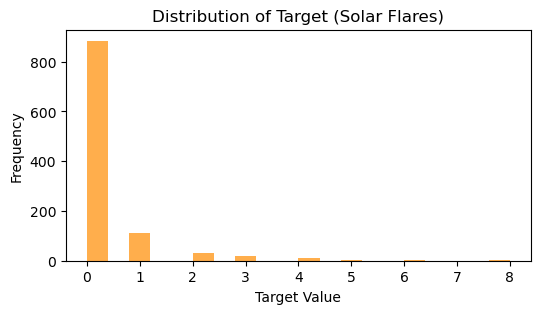

In [32]:
# --- Target 분포 시각화
plt.figure(figsize=(6,3))
plt.hist(y, bins=20, alpha=0.7, color='darkorange')
plt.title("Distribution of Target (Solar Flares)")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.show()


## 3) Preprocessing + Train/Test Split

In [44]:
target_col = 'target'
X = df.drop(columns=[target_col])
y = df[target_col]

# 모든 피처가 numeric이므로 OneHot 불필요
num_cols = X.columns.tolist()
print("Numeric feature columns:", num_cols)


Numeric feature columns: ['sunspot_group_configuration', 'sunspot_largest_spot', 'sunspot_distribution', 'sunspot_activity', 'sunspot_evolution', 'recent_flare_activity', 'historically_complex_region', 'historically_complex_region_recent', 'region_area', 'largest_spot_area']


In [48]:
# Train/Test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print("Train/Test:", X_tr.shape, X_te.shape)


Train/Test: (799, 10) (267, 10)


In [50]:
# Preprocessor: 스케일링만 적용 (회귀에서 안정적)
preprocessor = StandardScaler()


## 4) Baseline (Dummy Regressor)

In [53]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

dummy = Pipeline(steps=[
    ('scaler', preprocessor),
    ('reg', DummyRegressor(strategy='mean'))
])
dummy.fit(X_tr, y_tr)
y_dummy = dummy.predict(X_te)

print("Dummy | RMSE:", rmse(y_te, y_dummy),
      "MAE:", mean_absolute_error(y_te, y_dummy),
      "R²:", r2_score(y_te, y_dummy))


Dummy | RMSE: 0.7917695177286334 MAE: 0.48528825826290367 R²: -0.0020403725470974354


## 5) Model Registry + Cross-Validation Comparison

In [60]:
CV_SPLITS = 5
cv = KFold(n_splits=CV_SPLITS, shuffle=True, random_state=42)

registry = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, random_state=42, max_iter=5000),
    "DT": DecisionTreeRegressor(random_state=42),
    "RF": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
}

rows = []
for name, est in registry.items():
    pipe = Pipeline(steps=[('scaler', preprocessor), ('reg', est)])
    scores = cross_validate(
        pipe, X, y, cv=cv, n_jobs=-1,
        scoring={
            'r2':'r2',
            'neg_rmse':'neg_root_mean_squared_error',
            'neg_mae':'neg_mean_absolute_error'
        },
        return_train_score=False
    )
    rows.append({
        "Model": name,
        "CV RMSE (mean)": -scores['test_neg_rmse'].mean(),
        "CV MAE (mean)": -scores['test_neg_mae'].mean(),
        "CV R² (mean)": scores['test_r2'].mean()
    })

cv_df = pd.DataFrame(rows).sort_values("CV RMSE (mean)").reset_index(drop=True)
display(cv_df)


,Model,CV RMSE (mean),CV MAE (mean),CV R² (mean)
0,Lasso,0.786813,0.421387,0.105524
1,Ridge,0.787107,0.421791,0.104876
2,Linear,0.787141,0.421801,0.104799
3,RF,0.892535,0.454425,-0.160380
4,DT,0.971900,0.467389,-0.371803


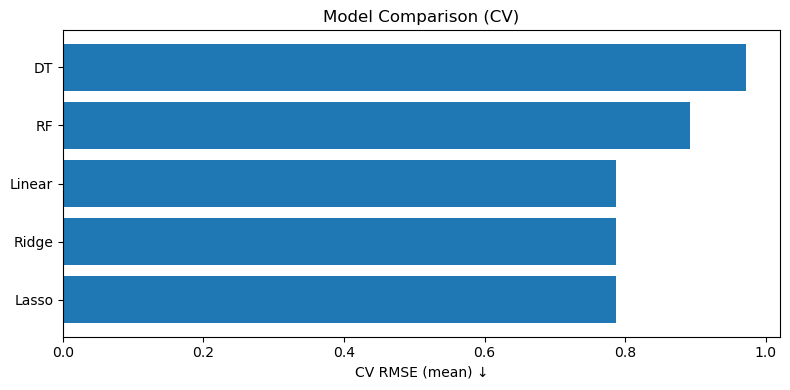

In [62]:
# 시각화 (RMSE 낮을수록 좋음)
plt.figure(figsize=(8,4))
plt.barh(cv_df["Model"], cv_df["CV RMSE (mean)"])
plt.xlabel("CV RMSE (mean) ↓")
plt.title("Model Comparison (CV)")
plt.tight_layout()
plt.show()


## 6) 하이퍼파라미터 튜닝 Cross-Validation Comparison

In [68]:
# RandomForestRegressor 그리드 탐색 (스케일러 포함 파이프라인)
rf_pipe = Pipeline(steps=[('scaler', preprocessor),
                          ('reg', RandomForestRegressor(random_state=42, n_jobs=-1))])
rf_grid = {
    'reg__n_estimators': [200, 400],
    'reg__max_depth': [None, 12, 20],
    'reg__min_samples_leaf': [1, 3, 5]
}
rf_gs = GridSearchCV(
    rf_pipe, rf_grid, cv=cv, n_jobs=-1, scoring='neg_root_mean_squared_error'
)
rf_gs.fit(X_tr, y_tr)
print("RF best params:", rf_gs.best_params_,
      "| best CV RMSE:", -rf_gs.best_score_)


RF best params: {'reg__max_depth': 12, 'reg__min_samples_leaf': 5, 'reg__n_estimators': 200} | best CV RMSE: 0.7905687669719992


In [72]:
# Ridge 그리드 탐색
ridge_pipe = Pipeline(steps=[('scaler', preprocessor),
                             ('reg', Ridge(random_state=42))])
ridge_grid = {'reg__alpha': [0.1, 1.0, 5.0, 10.0]}
ridge_gs = GridSearchCV(
    ridge_pipe, ridge_grid, cv=cv, n_jobs=-1, scoring='neg_root_mean_squared_error'
)
ridge_gs.fit(X_tr, y_tr)
print("Ridge best params:", ridge_gs.best_params_,
      "| best CV RMSE:", -ridge_gs.best_score_)


Ridge best params: {'reg__alpha': 10.0} | best CV RMSE: 0.7772410059582848


## 최종 모델 선택 & 테스트 평가 (Pred vs Actual/Residual Plot)

In [75]:
def rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(y_true, y_pred))

# CV RMSE가 낮은 모델 선택
rf_cv_rmse = -rf_gs.best_score_
ridge_cv_rmse = -ridge_gs.best_score_

if rf_cv_rmse <= ridge_cv_rmse:
    best_name = "RF"
    best_est = rf_gs.best_estimator_
    best_cv = rf_cv_rmse
else:
    best_name = "Ridge"
    best_est = ridge_gs.best_estimator_
    best_cv = ridge_cv_rmse

print("Selected:", best_name, "| CV RMSE:", best_cv)


Selected: Ridge | CV RMSE: 0.7772410059582848


In [77]:
# Test 성능
best_est.fit(X_tr, y_tr)
y_hat = best_est.predict(X_te)

print("Test RMSE:", rmse(y_te, y_hat))
print("Test MAE:", mean_absolute_error(y_te, y_hat))
print("Test R²:", r2_score(y_te, y_hat))


Test RMSE: 0.7546809659645393
Test MAE: 0.41564766262636105
Test R²: 0.08963729554296973


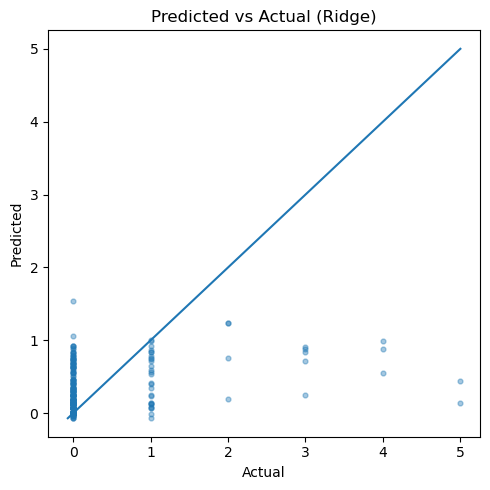

In [79]:
# Pred vs Actual
plt.figure(figsize=(5,5))
plt.scatter(y_te, y_hat, alpha=0.4, s=12)
lims = [min(y_te.min(), y_hat.min()), max(y_te.max(), y_hat.max())]
plt.plot(lims, lims)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual ({best_name})")
plt.tight_layout()
plt.show()


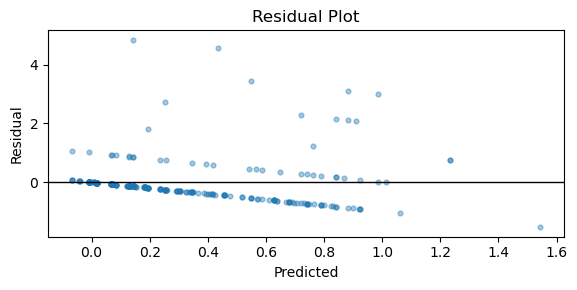

In [81]:
# Residual plot
resid = y_te - y_hat
plt.figure(figsize=(6,3))
plt.scatter(y_hat, resid, alpha=0.4, s=12)
plt.axhline(0, color='k', lw=1)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()


## Test Size 민감도 분석

,Test Size,RMSE,MAE,R²
0,0.20,0.820468,0.447721,0.095438
1,0.25,0.754681,0.415648,0.089637
2,0.30,0.783027,0.428671,0.066802
3,0.40,0.808640,0.426498,0.047361


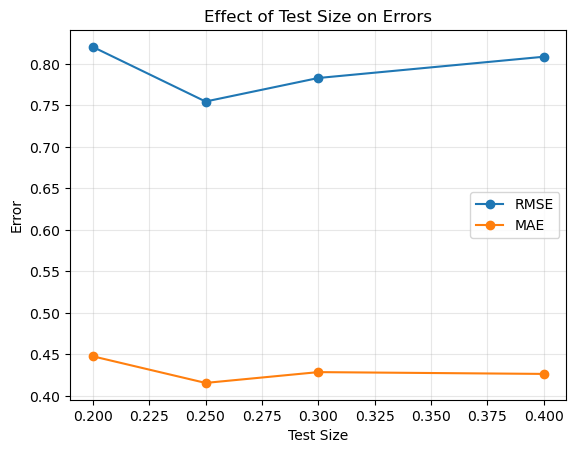

In [86]:
def eval_with_test_size(model_template, test_size):
    X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X, y, test_size=test_size, random_state=42)
    model = clone(model_template)
    model.fit(X_tr2, y_tr2)
    pred = model.predict(X_te2)
    return {"Test Size": test_size,
            "RMSE": np.sqrt(mean_squared_error(y_te2, pred)),
            "MAE": mean_absolute_error(y_te2, pred),
            "R²": r2_score(y_te2, pred)}

final_template = clone(best_est)
sizes = [0.2, 0.25, 0.3, 0.4]
sens = [eval_with_test_size(final_template, s) for s in sizes]
sens_df = pd.DataFrame(sens)
display(sens_df)

plt.figure()
plt.plot(sens_df["Test Size"], sens_df["RMSE"], marker='o', label="RMSE")
plt.plot(sens_df["Test Size"], sens_df["MAE"], marker='o', label="MAE")
plt.xlabel("Test Size"); plt.ylabel("Error")
plt.title("Effect of Test Size on Errors")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Discussion (Analysis & Interpretation)
In this regression task, we evaluated multiple models—including Linear Regression, Ridge, Lasso, Decision Tree, and Random Forest—using 5-fold cross-validation on RMSE, MAE, and R². The baseline DummyRegressor achieved an RMSE of 0.79 and an R² close to 0.0, showing almost no predictive capability. Compared to this baseline, the linear family of models (Lasso, Ridge, Linear Regression) consistently produced lower CV errors, with Ridge performing the best among them.
The CV results clearly show that Ridge, Lasso, and Linear Regression outperform tree-based models (Decision Tree and Random Forest). This indicates that the solar flare target variable has mostly weak, linear relationships with the predictors, and does not benefit from deep non-linear partitioning, which explains the poor performance of RF (negative R²) and DT. Among the linear models, Ridge achieved the best CV RMSE (0.777), suggesting that L2 regularization effectively stabilizes the model by reducing coefficient variance.
On the test set, Ridge produced an RMSE of 0.755, MAE of 0.416, and R² of 0.089. While the overall R² is modest, the model still provides a meaningful improvement over the baseline and demonstrates that the dataset likely has limited predictive signal and moderate noise, rather than being highly model-dependent. The Test-Size Sensitivity experiment further confirms stability: RMSE only fluctuated slightly across splits (0.82 → 0.75 → 0.78 → 0.81), meaning the model generalizes consistently even when the training sample size changes.


Final Conclusion
The best model for the Solar Flares dataset is Ridge Regression, selected due to its superior cross-validation RMSE and stable generalization performance. The dataset does not exhibit strong non-linear patterns, which is why tree-based methods underperformed, while linear models with regularization were more effective. Although the final R² score is relatively low, the model’s stability across splits and its clear improvement over the baseline make Ridge the most suitable choice for this task.


Reflection (Required by assignment: “Is there one best model for all datasets?”)
This project demonstrates that there is no single best machine learning model for all datasets. In the Connect-4 classification problem, the data were highly categorical and non-linear, which made Random Forest with one-hot encoding the best performer. However, in the Solar Flares regression dataset, the underlying patterns were closer to linear and weak in signal, so Ridge Regression performed best, outperforming tree-based methods. These results reinforce a key principle: model performance depends on the data’s structure and inductive bias, and therefore model selection must always be data-driven, not model-driven.